In [3]:
from skimage.transform import resize
from itertools import product
from collections import OrderedDict
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

from thirdparty.Run import RunBuilder as RB
from thirdparty.Run import RunManager as RM

%run DataLoader.ipynb
%run Visualization.ipynb

device = torch.device("cuda")

# Model Definition

In [4]:
import torch
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F


class Convolution3D(nn.Module):
    def __init__(self):
        super(Convolution3D,self).__init__()
        self.Convolution1 = nn.Conv3d(in_channels = 3, out_channels = 64, kernel_size=(3,3,3), stride=1, padding=(1,0,0), dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.BatchN1 = nn.BatchNorm3d(num_features = 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.MaxPooling1 = nn.MaxPool3d(kernel_size = (1,2,2), stride=(1,2,2), padding=(0,0,0), dilation=1, return_indices=False, ceil_mode=False)
        self.MaxPooling2 = nn.MaxPool3d(kernel_size =(1,2,2), stride=(1,2,2), padding=(0,0,0), dilation=1, return_indices=False, ceil_mode=False)
        
        self.Convolution2 = nn.Conv3d(in_channels = 64, out_channels = 64,kernel_size=3,stride = 1, padding = (1,0,0))
        self.BatchN2 = nn.BatchNorm3d(num_features = 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.ResConvolution1 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = (1,1,1))
        self.averagePool1 = nn.AvgPool3d(kernel_size = 1, stride =1, padding = (0,0,0))
        self.ResBatchN1 = nn.BatchNorm3d(num_features = 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.Convolution3 = nn.Conv3d(in_channels = 64, out_channels = 64,kernel_size=3,stride = 1, padding = (1,0,0))
        self.BatchN3 = nn.BatchNorm3d(num_features = 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.ResConvolution2 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = (1,1,1))
        self.averagePool2 = nn.AvgPool3d(kernel_size = 1, stride =1, padding = (0,0,0) )
        self.ResBatchN2 = nn.BatchNorm3d(num_features = 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.Convolution4 = nn.Conv3d(in_channels = 64, out_channels = 8, kernel_size=(3,3,3), stride=1, padding=(1,0,0), dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.BatchN4 = nn.BatchNorm3d(num_features = 8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.Convolution5 = nn.Conv3d(in_channels = 8, out_channels = 8, kernel_size=(3,3,3), stride=1, padding=(1,0,0), dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.BatchN5 = nn.BatchNorm3d(num_features = 8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.Convolution6 = nn.Conv3d(in_channels = 8, out_channels = 8, kernel_size=(3,3,3), stride=1, padding=(1,0,0), dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.BatchN6 = nn.BatchNorm3d(num_features = 8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.Flatten1 = nn.Flatten(start_dim=2)
        
        self.LSTM1 = nn.LSTM(input_size = 10488, hidden_size = 64, num_layers = 1, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size = 64, hidden_size = 16, num_layers = 1, batch_first=True)
        
        self.fc1 = nn.Linear(in_features =16, out_features = 512, bias=True)
        self.fc2 = nn.Linear(in_features = 512, out_features = 128, bias=True)
        self.fc3 = nn.Linear(in_features = 128, out_features = 64, bias=True)
        self.fc4 = nn.Linear(in_features = 64, out_features = 16, bias=True)
        self.fc5 = nn.Linear(in_features = 16, out_features = 1, bias=True)
    def forward(self, Input):
        # 3*3*3 3D Conv 3
        image = F.relu(self.BatchN1(self.Convolution1(Input)))
        # input size = (1,3,15,120,320)-(Batches, Channels, Depth, Height, Width)
        # output size = (1, 64, 13, 118, 318)-(Batches, Channels, Depth, Height, Width)
        
        # 3D Max Pooling
        image = self.MaxPooling1(image)
        # input size = (1, 64, 13, 118, 318)-(Batches, Channels, Depth, Height, Width)
        # output size = (1, 64, 12, 117, 317)-(Batches, Channels, Depth, Height, Width)
        
        # 3D Max Pooling
        image = self.MaxPooling2(image)
        # input size = (1, 64, 12, 117, 317)-(Batches, Channels, Depth, Height, Width)
        # output size = (1, 64, 11, 116, 316)-(Batches, Channels, Depth, Height, Width)
        
        # 3*3*3 3D Conv 64
        image = F.relu(self.BatchN2(self.Convolution2(image)))
        
        # ResNet - 3*3*3 3D Conv 64
        Residual = image
        Res_Output = F.relu(self.ResBatchN1(self.ResConvolution1(image)))
        image = F.relu(Residual + Res_Output)
        image = self.averagePool1(image)
        
        # 3*3*3 3D Conv 64
        image = F.relu(self.BatchN3(self.Convolution3(image)))
        
        # ResNet - 3*3*3 3D Conv 64
        Residual = image
        Res_Output = F.relu(self.ResBatchN2(self.ResConvolution2(image)))
        image = F.relu(Residual + Res_Output)
        del Residual
        del Res_Output
        image = self.averagePool2(image)
        
        # 3*3*3 3D Conv 8
        image = F.relu(self.BatchN4(self.Convolution4(image)))
        
        # 3*3*3 3D Conv 8
        image = F.relu(self.BatchN5(self.Convolution5(image)))
        
        # 3*3*3 3D Conv 8
        image = F.relu(self.BatchN6(self.Convolution6(image)))
        
        # LSTM 64
        image = image.permute([0,2,1,3,4])
        image = self.Flatten1(image)
        image = self.LSTM1(image)
        image = image[0]
        image = torch.tanh(image)
        
        # LSTM 16
        image = torch.tanh(self.LSTM2(image)[0])

        # FC 512
        image = image.permute(1,0,2)
        image = F.relu(self.fc1(image))
 
        # FC 128
        image = F.relu(self.fc2(image))

        # FC 64
        image = F.relu(self.fc3(image))
 
        # FC 16
        image = F.relu(self.fc4(image))

        # FC 1
        image = self.fc5(image)

        return image

# Model Training / Loading

In [ ]:
parameters = OrderedDict(
    file = ['3DCNN_Paper'], # used to mark specific files in case that we want to check them on tensorboard
    learning_rate = [0.001],
    batch_size = [5],
    seq_len = [5],
    num_workers = [2],
)
m = RM.RunManager()

for run in RB.RunBuilder.get_runs(parameters):
    network = Convolution3D().to(device)

    optimizer = optim.Adam(network.parameters(),lr = run.learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)

    udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera')

    dataset_size = int(len(udacity_dataset))
    del udacity_dataset
    split_point = int(dataset_size * 0.8)

    training_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera',
                                     select_range=(0,split_point))
    validation_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera',
                                     select_range=(split_point,dataset_size))

    training_cbs = ConsecutiveBatchSampler(data_source=training_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=run.seq_len)
    training_loader = DataLoader(training_set, sampler=training_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))
    
    validation_cbs = ConsecutiveBatchSampler(data_source=validation_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=run.seq_len)
    validation_loader = DataLoader(validation_set, sampler=validation_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))
    
    m.begin_run( run,network,[run.batch_size,3,run.seq_len,120,320] )
    for epoch in range(10):
        m.begin_epoch()
# Calculation on Training Loss
        for training_sample in tqdm(training_loader, total=int(len(training_set)/run.batch_size/run.seq_len)):
            training_sample['image'] = torch.Tensor(resize(training_sample['image'], (run.batch_size,run.seq_len,3,120,320),anti_aliasing=True))
            training_sample['image'] = training_sample['image'].permute(0,2,1,3,4)
            
            param_values = [v for v in training_sample.values()]
            image,angle = param_values[0],param_values[3]
            image = image.to(device)
            prediction = network(image)
            prediction = prediction.squeeze().permute(1,0).to(device)
            labels = angle.to(device)
            del param_values, image, angle
            if labels.shape[0]!=prediction.shape[0]:
                prediction = prediction[-labels.shape[0],:]
            training_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
            optimizer.zero_grad()# zero the gradient that are being held in the Grad attribute of the weights
            training_loss_angle.backward() # calculate the gradients
            optimizer.step() # finishing calculation on gradient
        print("Done")
# Calculation on Validation Loss
        with torch.no_grad():    
            for Validation_sample in tqdm(validation_loader, total=int(len(validation_set)/run.batch_size/run.seq_len)):
                Validation_sample['image'] = torch.Tensor(resize(Validation_sample['image'], (run.batch_size,run.seq_len,3,120,320),anti_aliasing=True))
                Validation_sample['image'] = Validation_sample['image'].permute(0,2,1,3,4)

                param_values = [v for v in Validation_sample.values()]
                image,angle = param_values[0],param_values[3]
                image = image.to(device)
                prediction = network(image)
                prediction = prediction.squeeze().permute(1,0).to(device)
                labels = angle.to(device)
                del param_values, image, angle
                if labels.shape[0]!=prediction.shape[0]:
                    prediction = prediction[-labels.shape[0],:]
                validation_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
                m.track_loss(validation_loss_angle)
                m.track_num_correct(prediction,labels) 
        m.end_epoch(validation_set)
        torch.save(network.state_dict(), "saved_models/CNN3D/epoch-{}".format(epoch))
    m.end_run()
m.save('result')

In [5]:
# Load model directly from disk

cnn3d_model = Convolution3D().to(device)
cnn3d_model.load_state_dict(torch.load('saved_models/CNN3D/3DCNN_Model-epoch-4'))

<All keys matched successfully>

(64, 3, 3, 3, 3)


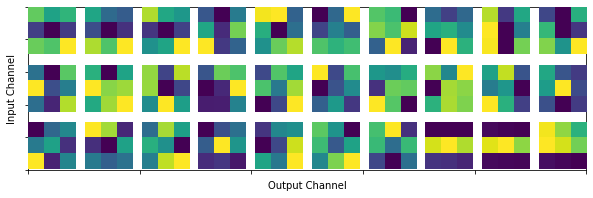

In [9]:
visualize_cnn(cnn3d_model.Convolution1)

## Model Evaluation

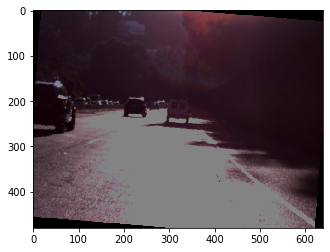

In [52]:
cnn_cam_extractor = CamExtractor3DCNN(cnn3d_model)

Batch_size = 5
Seq_len = 5 


udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')

# 3D CNN has different input batch size and seq_len, so we define new CBS and Loader
cbs_3dcnn = ConsecutiveBatchSampler(data_source=udacity_dataset, batch_size=Batch_size, shuffle=False, drop_last=False, seq_len=Seq_len, use_all_frames=True)
loader_3dcnn = DataLoader(udacity_dataset, sampler=cbs_3dcnn, collate_fn=(lambda x: x[0]))

In [ ]:
mse_loss = nn.MSELoss()

angle_pred_history = []
angle_true_history = []

frame_count = 0
for i, testing_sample in enumerate(tqdm(loader_3dcnn, total=len(loader_3dcnn))):
    testing_sample['image'] = torch.Tensor(resize(testing_sample['image'], (Batch_size,Seq_len,3,120,320), anti_aliasing=True))
    image_input = testing_sample['image'].permute(0,2,1,3,4).to(device)
    prediction = cnn3d_model(image_input).squeeze()
    target = testing_sample['angle'].squeeze().to(device)
    loss = mse_loss(prediction, target)
    loss.backward()
    
    cam_image = cnn_cam_extractor.to_image(width=320, height=120) # Use this line to extract CAM image from the model!
    
    
    for b in range(Batch_size):
        fig, ax = plt.subplots()
        show_image_single(ax, testing_sample['image'][b, -1, :, :, :].permute(1, 2, 0),
                          angle_pred=prediction[b, -1].cpu().detach().numpy()*30,
                          speed=testing_sample['speed'][b, -1].detach().numpy(),
                          angle_true=testing_sample['angle'][b, -1].detach().numpy()*30)
        
        angle_pred_history.append(float(prediction[b, -1].cpu().detach().numpy()))
        angle_true_history.append(float(testing_sample['angle'][b, -1].detach().numpy()))
    
        plt.savefig("cam_images/steering-{}".format(frame_count))
        frame_count += 1
        plt.close()
    
fig, ax = plt.subplots()
ax.plot(angle_pred_history, color='red', label='predicted')
ax.plot(angle_true_history, color='blue', label='true')
ax.legend()

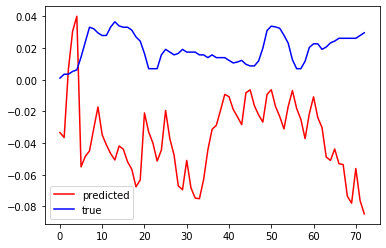

In [55]:
fig, ax = plt.subplots()

ax.plot(angle_pred_history, color='red', label='predicted')
ax.plot(angle_true_history, color='blue', label='true')

ax.legend()
